In [2]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from scipy import optimize
from scipy.linalg import det
import sys
sys.path.append('../')

from scripts.compute_covariance import compute_covariance

In [3]:
nside=256
npix=hp.nside2npix(nside)
freqs=np.arange(544,1088,step=10)
nfreqs=len(freqs)-1
lmax=3*nside -1
almsize=hp.Alm.getsize(lmax)

In [4]:
hi_maps= np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_hi_maps.npy")
# hi_maps= np.load("/home/urwa/MASS_Thesis/HI/hi_corr_maps.npy")
# noise_maps= np.load("/home/urwa/MASS_Thesis/Thesis/noise_nf.npy")*1e3
# ff=np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_ff_maps.npy")
# sync=np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_sync_maps.npy")
# ff=np.load("/home/iloveorcas/MASS_Thesis/results_2/ff_maps.npy")
# sync=np.load("/home/iloveorcas/MASS_Thesis/results_2/sync_maps.npy")
# hi_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/smoothed_hi_maps.npy")
# noise_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/noise_nf.npy")

# fgds=ff+sync/1e8
cl_hi=compute_covariance(hi_maps, lmax, almsize, nfreqs)
# cl_noise= compute_covariance(noise_maps, lmax, almsize, nfreqs)
# cl_fgds= compute_covariance(fgds, lmax, almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [5]:
def bin_spectra(cl, delta):
    b= nmt.NmtBin.from_lmax_linear(lmax, nlb=delta)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()
    cl_binned= np.zeros((n_bins, nfreqs, nfreqs))

    for i in range(nfreqs):
        for j in range(nfreqs):
            cl_binned[:, i, j] = b.bin_cell(cl[:, i, j])
            
    return leff,n_bins,cl_binned

In [6]:
leff, nbins,hi_binned= bin_spectra(cl_hi, 10)
# *_,noise_binned= bin_spectra(cl_noise, 10)
# *_, fgds_binned= bin_spectra(cl_fgds, 10)
# total=hi_maps + noise_maps[:54] +fgds
# cl_hat=compute_covariance(total, lmax, almsize, nfreqs)
# *_, chat_binned= bin_spectra(cl_hat, 10)

In [7]:
def diagonalize_matrices(cl, nfreqs):
    cl_diag=np.zeros((nbins, nfreqs, nfreqs))
    for l in range (nbins):
        #print(f"Diagonalizing matrix {l}")
        cl_diag[l,:,:]= np.identity(nfreqs)*cl[l,:,:]
    return cl_diag
hi_d= diagonalize_matrices(hi_binned, nfreqs)
#print(hi_d[10])

In [51]:
n_v = 18         
M = np.zeros((nfreqs, n_v))

bins_per_v = nfreqs // n_v  # 3
print(bins_per_v)

for v in range(n_v):
    b_start = v * bins_per_v
    b_end = (v + 1) * bins_per_v
    M[b_start:b_end, v] = 1 / bins_per_v  # uniform average

3


In [19]:
print(M.shape)

(54, 18)


In [80]:
# degree=5
# log_ell = np.log10(leff)
# coeffs = np.zeros((degree+1, nfreqs))
# for b in range(nfreqs):
#     log_hi_b = np.log10(hi_d[:, b, b])
#     coeffs[:, b] = np.polyfit(log_ell, log_hi_b, degree)
# # 2) rebin: a_pv = sum_b coeffs[p,b] * M[b,v]
# #    result has shape (degree+1, n_v)
# a_pv = coeffs @ M 
# print(a_pv.shape)
# # log_hi_fit: shape (n_ell, n_v)
# log_hi_fit = np.array([np.polyval(a_pv[:, v], log_ell) for v in range(a_pv.shape[1])]).T

# # hi_fit: same shape, with actual (non-log) values
# hi_fit = 10 ** log_hi_fit
# print(hi_fit.shape)

In [176]:
degree = 3
log_ell = np.log10(leff)  
coeffs = np.zeros((degree + 1, nfreqs))

#Fit diagonal of each freq bin
for b in range(nfreqs):
    log_hi_b = np.log10(hi_d[:, b, b])  #(n_ell,)
    coeffs[:, b] = np.polyfit(log_ell, log_hi_b, degree)

#Rebin a_pv has shape (degree+1, n_v)
a_pv = coeffs @ M  

print( a_pv.shape)

#full model covariance (n_ell, n_v, n_v)
n_ell = len(log_ell)
n_v = M.shape[1]
hi_fit = np.zeros((n_ell, n_v, n_v))

for i in range(n_ell):
    #polynomial rebinned freq bin v
    diag_log = np.array([np.polyval(a_pv[:, v], log_ell[i]) for v in range(n_v)])
    
    # Diagonal matrix in log space
    C_log = np.diag(diag_log)  # shape: (n_v, n_v)

    # Convert back from log10
    C_fit_diag = 10 ** C_log

    #Project to full rebinned covariance: M^T C M
    
    #full covariance from diagonal-only:
    C_full_orig = np.zeros((nfreqs, nfreqs))
    for b in range(nfreqs):
        C_full_orig[b, b] = 10 ** np.polyval(coeffs[:, b], log_ell[i])

    # Project entire C_full_orig to rebinned space
    hi_fit[i] = M.T @ C_full_orig @ M

print("hi_fit shape:", hi_fit.shape)  # should be (n_ell, n_v, n_v)


(4, 18)
hi_fit shape: (76, 18, 18)


In [177]:
# Step 1: Pseudoinverse of the binning matrix
M_plus = np.linalg.pinv(M)  # shape: (n_v, n_freq)

# Step 2: Unbin each covariance matrix
n_ell, n_v, _ = hi_fit.shape
n_freq = M.shape[0]
print(M_plus.shape)  # should be (n_v, n_freq)
hi_fit_unbinned = np.zeros((n_ell, n_freq, n_freq))

for i in range(n_ell):
    hi_fit_unbinned[i,:,:] = M_plus.T @ hi_fit[i,:,:] @ M_plus

print("hi_fit_unbinned shape:", hi_fit_unbinned.shape)  # should be (n_ell, n_freq, n_freq)


(18, 54)
hi_fit_unbinned shape: (76, 54, 54)


In [178]:
# hi_empirical_rebinned = np.einsum('ebb,bv->ev', hi_d, M)
# print(hi_empirical_rebinned.shape)

In [179]:
# plt.plot(leff,hi_fit[:,13], label='Fitted HI')
# plt.plot(leff, hi_empirical_rebinned[:,13], label='Binned HI')
# plt.legend()
# plt.show()


In [192]:
# hi_empirical: shape (n_ell, n_freq, n_freq)
# M: shape (n_freq, n_v)

n_ell, n_freq, _ = hi_d.shape
n_v = M.shape[1]

hi_b = np.zeros((n_ell, n_v, n_v))

for i in range(n_ell):
    hi_b[i] = M.T @ hi_d[i] @ M

print(hi_b.shape)  # (n_ell, n_v, n_v)

(76, 18, 18)


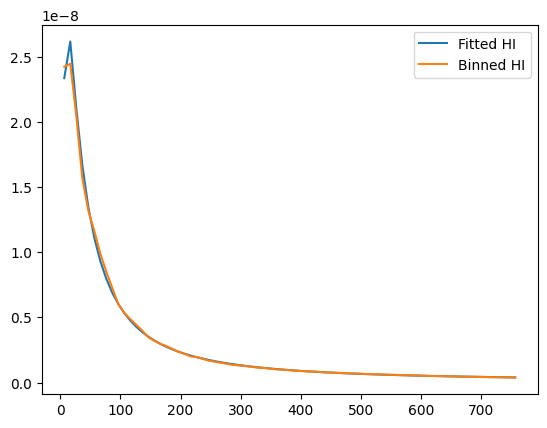

In [206]:
plt.plot(leff,hi_fit_unbinned[:,0,0], label='Fitted HI')
plt.plot(leff, hi_b[:,0,0], label='Binned HI')
plt.legend()
plt.show()


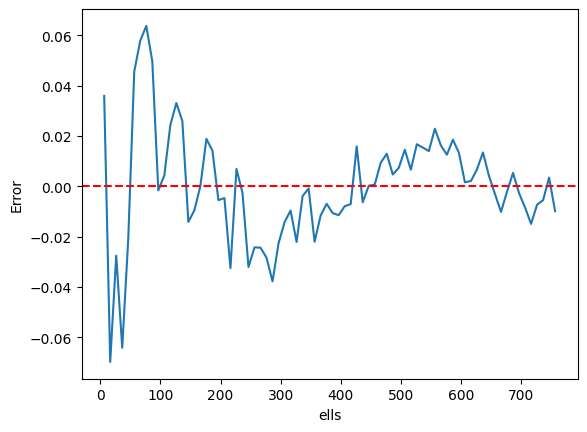

In [210]:
v=0
err= (hi_b[:,v,v]- hi_fit_unbinned[:,v,v])/hi_b[:,v,v]
plt.plot(leff, err)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('ells')
plt.ylabel('Error')
plt.show()

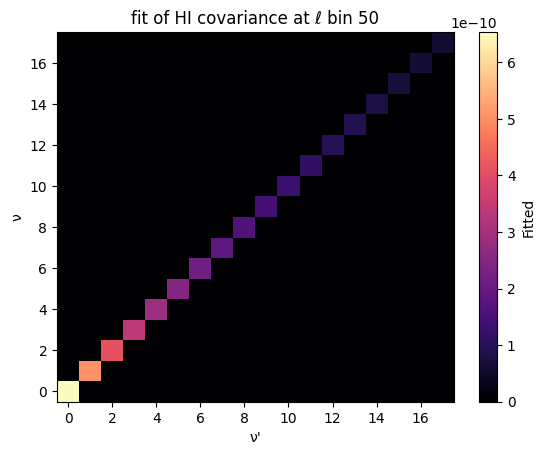

In [196]:
l=50
plt.imshow(hi_fit[l], origin='lower', cmap='magma', aspect='auto') #, vmin=0, vmax=1.5e-9
plt.colorbar(label='Fitted')
plt.title(f"fit of HI covariance at ℓ bin {l}")
plt.xlabel("ν'")
plt.ylabel("ν")
plt.show()

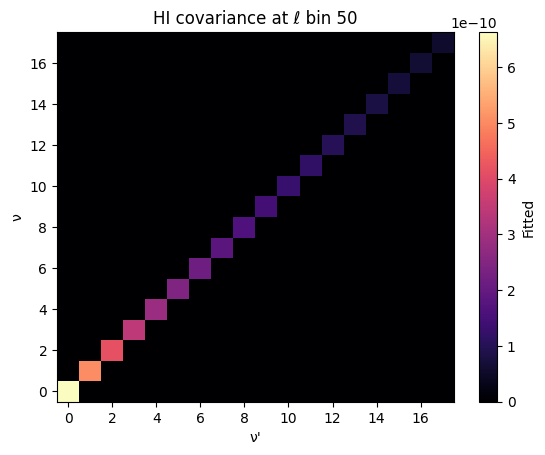

In [197]:
plt.imshow(hi_b[l], origin='lower', cmap='magma', aspect='auto') #, vmin=0, vmax=1.5e-9
plt.colorbar(label='Fitted')
plt.title(f"HI covariance at ℓ bin {l}")
plt.xlabel("ν'")
plt.ylabel("ν")
plt.show()